In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="CG",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:05,  5.21it/s]
27it [00:03,  6.76it/s]
27it [00:03,  7.31it/s]
27it [00:03,  7.18it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.09it/s]
27it [00:03,  6.99it/s]
27it [00:03,  7.40it/s]
27it [00:03,  6.78it/s]
27it [00:04,  6.50it/s]
27it [00:03,  7.24it/s]
27it [00:03,  7.30it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.29it/s]
27it [00:03,  7.18it/s]
27it [00:03,  8.00it/s]
27it [00:03,  6.78it/s]
27it [00:04,  6.75it/s]
27it [00:04,  5.53it/s]
27it [00:04,  6.73it/s]
27it [00:04,  6.60it/s]
27it [00:03,  6.82it/s]
27it [00:03,  6.93it/s]
27it [00:03,  7.43it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.25it/s]
27it [00:03,  6.99it/s]
27it [00:03,  7.29it/s]
27it [00:04,  6.68it/s]
27it [00:03,  7.42it/s]
27it [00:03,  7.75it/s]
27it [00:03,  7.86it/s]
27it [00:03,  7.50it/s]
27it [00:03,  8.08it/s]
27it [00:03,  7.97it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.58it/s]
27it [00:03,  7.59it/s]
27it [00:03,  7.44it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.

27it [00:03,  8.39it/s]
27it [00:03,  8.30it/s]
27it [00:03,  8.31it/s]
27it [00:03,  8.31it/s]
27it [00:03,  8.60it/s]
27it [00:03,  8.60it/s]
27it [00:03,  8.51it/s]
27it [00:03,  7.58it/s]
27it [00:03,  8.13it/s]
27it [00:03,  8.44it/s]
27it [00:02, 10.40it/s]
27it [00:03,  7.00it/s]
27it [00:04,  6.34it/s]
27it [00:04,  6.49it/s]
27it [00:03,  6.84it/s]
27it [00:04,  5.97it/s]
27it [00:04,  6.26it/s]
27it [00:03,  7.03it/s]
27it [00:03,  7.51it/s]
27it [00:04,  6.24it/s]
27it [00:03,  7.36it/s]
27it [00:03,  7.24it/s]
27it [00:03,  8.15it/s]
27it [00:03,  8.06it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.16it/s]
27it [00:03,  7.87it/s]
27it [00:03,  7.69it/s]
27it [00:03,  8.20it/s]
27it [00:03,  8.10it/s]
27it [00:03,  7.81it/s]
27it [00:03,  8.03it/s]
27it [00:03,  8.29it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.40it/s]
27it [00:03,  8.32it/s]
27it [00:03,  7.98it/s]
27it [00:03,  8.19it/s]
27it [00:03,  8.02it/s]
27it [00:03,  8.14it/s]
27it [00:03,  8.30it/s]
27it [00:03,  7.

27it [00:03,  7.89it/s]
27it [00:03,  7.37it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.95it/s]
27it [00:03,  8.09it/s]
27it [00:03,  7.65it/s]
27it [00:03,  7.85it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.75it/s]
27it [00:03,  7.89it/s]
27it [00:03,  8.44it/s]
27it [00:03,  7.95it/s]
27it [00:03,  8.02it/s]
27it [00:03,  7.83it/s]
27it [00:03,  8.00it/s]
27it [00:03,  7.59it/s]
27it [00:03,  8.00it/s]
27it [00:03,  8.04it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.50it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.82it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.91it/s]
27it [00:03,  8.05it/s]
27it [00:03,  7.81it/s]
27it [00:03,  8.18it/s]
27it [00:03,  8.10it/s]
27it [00:03,  8.10it/s]
27it [00:03,  7.80it/s]
27it [00:03,  7.99it/s]
27it [00:03,  8.09it/s]
27it [00:03,  8.18it/s]
27it [00:03,  7.69it/s]
27it [00:03,  8.07it/s]
27it [00:03,  8.08it/s]
27it [00:03,  8.27it/s]
27it [00:03,  7.84it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.79it/s]
27it [00:03,  7.

         Current function value: -7.650140
         Iterations: 0
         Function evaluations: 837
         Gradient evaluations: 25
[3.36733227 5.26358482 2.29422402 1.63381407 1.37382874 0.02563013
 4.49871498 4.37306331 3.98037235 0.1387082  0.80998574 1.055139
 0.57465126 4.28441651 2.14631536 0.93953249 0.05248521 1.33271022
 0.77538525 5.94961933 2.30527423 2.59486904 4.97745694 2.11948801
 0.33934955 6.05395996 1.5515106  5.00702319 2.41896456 5.03299363
 0.46575459 2.67347773]


27it [00:03,  7.51it/s]

CPU times: total: 44min 50s
Wall time: 49min 5s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.6448364085882785

Approximation Error
0.027717543151883666


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


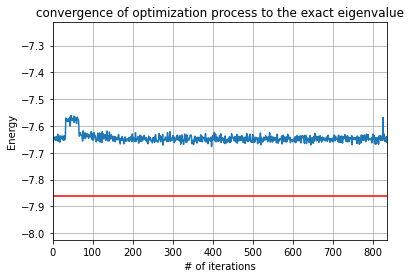

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:03,  7.28it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.40it/s]
27it [00:03,  7.39it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.11it/s]
27it [00:03,  7.26it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.33it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.31it/s]
27it [00:03,  7.37it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.46it/s]
27it [00:03,  7.39it/s]
27it [00:03,  7.32it/s]
27it [00:03,  7.52it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.28it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.55it/s]
27it [00:03,  7.44it/s]
27it [00:03,  7.30it/s]
27it [00:03,  7.62it/s]
27it [00:03,  7.75it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.68it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.14it/s]
27it [00:03,  7.71it/s]
27it [00:03,  7.78it/s]
27it [00:03,  8.00it/s]
27it [00:03,  8.17it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.64it/s]
27it [00:03,  7.83it/s]
27it [00:03,  7.91it/s]
27it [00:03,  8.22it/s]
27it [00:03,  7.

27it [00:03,  8.01it/s]
27it [00:03,  7.54it/s]
27it [00:03,  7.75it/s]
27it [00:03,  7.79it/s]
27it [00:03,  7.41it/s]
27it [00:03,  7.99it/s]
27it [00:03,  7.58it/s]
27it [00:04,  6.62it/s]
27it [00:03,  7.77it/s]
27it [00:03,  8.03it/s]
27it [00:03,  7.31it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.78it/s]
27it [00:03,  7.48it/s]
27it [00:03,  7.97it/s]
27it [00:03,  7.65it/s]
27it [00:03,  8.01it/s]
27it [00:03,  7.50it/s]
27it [00:03,  7.90it/s]
27it [00:03,  7.88it/s]
27it [00:03,  7.53it/s]
27it [00:03,  7.97it/s]
27it [00:03,  7.66it/s]
27it [00:03,  7.75it/s]
27it [00:03,  7.57it/s]
27it [00:03,  7.21it/s]
27it [00:03,  7.72it/s]
27it [00:03,  7.63it/s]
27it [00:03,  8.10it/s]
27it [00:03,  7.92it/s]
27it [00:03,  8.13it/s]
27it [00:03,  7.49it/s]
27it [00:03,  7.92it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.76it/s]
27it [00:03,  7.92it/s]
27it [00:03,  7.77it/s]
27it [00:03,  7.68it/s]
27it [00:03,  8.14it/s]
27it [00:03,  7.94it/s]
27it [00:03,  7.67it/s]
27it [00:03,  7.

27it [00:05,  5.25it/s]
27it [00:05,  5.38it/s]
27it [00:04,  5.68it/s]
27it [00:04,  6.13it/s]
27it [00:04,  5.75it/s]
27it [00:04,  6.04it/s]
27it [00:04,  5.51it/s]
27it [00:04,  5.71it/s]
27it [00:04,  5.87it/s]
27it [00:04,  5.95it/s]
27it [00:04,  5.51it/s]
27it [00:04,  6.53it/s]
27it [00:04,  5.42it/s]
27it [00:04,  6.02it/s]
27it [00:04,  5.97it/s]
27it [00:03,  7.58it/s]
27it [00:04,  6.02it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.40it/s]
27it [00:04,  5.66it/s]
27it [00:04,  5.65it/s]
27it [00:05,  5.07it/s]
27it [00:04,  5.78it/s]
27it [00:04,  5.67it/s]
27it [00:04,  6.74it/s]
27it [00:04,  5.92it/s]
27it [00:05,  5.39it/s]
27it [00:05,  4.96it/s]
27it [00:05,  4.86it/s]
27it [00:03,  7.40it/s]
27it [00:03,  6.88it/s]
27it [00:03,  8.30it/s]
27it [00:03,  8.65it/s]
27it [00:03,  8.39it/s]
27it [00:03,  8.69it/s]
27it [00:03,  8.25it/s]
27it [00:03,  8.88it/s]
27it [00:03,  8.43it/s]
27it [00:03,  8.56it/s]
27it [00:02,  9.11it/s]
27it [00:03,  8.64it/s]
27it [00:03,  7.

         Current function value: -7.527048
         Iterations: 4
         Function evaluations: 835
         Gradient evaluations: 25
[4.36027849 4.65182137 1.58679582 3.67748462 3.15873051 1.34594762
 1.65406705 0.70478402 4.84729527 2.07315878 0.00955375 1.6198831
 4.92883624 5.81010915 1.40146582 2.49364543 4.3059223  4.42085182
 1.98195174 3.9308842  0.2543875  6.11472907 3.67512192 0.86764289
 2.87448316 2.49838709 3.17984274 1.21613529 5.98742094 0.33517298
 6.27825418 3.2441596 ]


27it [00:02,  9.37it/s]

CPU times: total: 46min 38s
Wall time: 58min 1s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.517113499149078

Approximation Error
0.043961545972640896


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


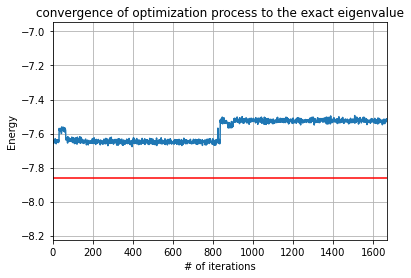

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01,  9.66it/s]
15it [00:01, 11.18it/s]
15it [00:01,  9.62it/s]
15it [00:01,  9.42it/s]
15it [00:01,  9.67it/s]
15it [00:01, 10.26it/s]
15it [00:01,  9.61it/s]
15it [00:01,  8.64it/s]
15it [00:01,  9.98it/s]
15it [00:01,  9.73it/s]
15it [00:01,  9.61it/s]
15it [00:01,  9.18it/s]
15it [00:01,  9.29it/s]
15it [00:01, 10.95it/s]
15it [00:01, 11.02it/s]
15it [00:01, 10.91it/s]
15it [00:01, 11.27it/s]
15it [00:01, 13.14it/s]
15it [00:01, 11.22it/s]
15it [00:01, 12.81it/s]
15it [00:01, 11.74it/s]
15it [00:01, 12.49it/s]
15it [00:01, 12.18it/s]
15it [00:01, 11.05it/s]
15it [00:01, 11.02it/s]
15it [00:01, 10.91it/s]
15it [00:01, 10.78it/s]
15it [00:01, 13.17it/s]
15it [00:01, 11.42it/s]
15it [00:01, 11.35it/s]
15it [00:01, 11.91it/s]
15it [00:01, 12.16it/s]
15it [00:01, 10.37it/s]
15it [00:01, 12.55it/s]
15it [00:01, 11.31it/s]
15it [00:01, 11.33it/s]
15it [00:01, 10.20it/s]
15it [00:01, 11.77it/s]
15it [00:01, 11.44it/s]
15it [00:01, 10.97it/s]
15it [00:01, 11.31it/s]
15it [00:01, 11.

15it [00:01,  9.15it/s]
15it [00:01,  9.85it/s]
15it [00:01,  8.29it/s]
15it [00:01,  8.71it/s]
15it [00:01,  9.18it/s]
15it [00:01, 11.95it/s]
15it [00:01,  9.73it/s]
15it [00:01,  9.67it/s]
15it [00:01,  9.41it/s]
15it [00:01, 10.20it/s]
15it [00:01,  9.52it/s]
15it [00:01,  9.77it/s]
15it [00:01,  9.42it/s]
15it [00:01,  8.37it/s]
15it [00:01,  9.19it/s]
15it [00:01,  8.49it/s]
15it [00:01,  8.84it/s]
15it [00:01, 10.43it/s]
15it [00:01,  8.65it/s]
15it [00:01,  8.55it/s]
15it [00:01,  9.48it/s]
15it [00:01,  9.74it/s]
15it [00:01,  9.50it/s]
15it [00:01,  9.04it/s]
15it [00:01,  8.01it/s]
15it [00:01,  9.21it/s]
15it [00:01,  8.15it/s]
15it [00:01,  8.58it/s]
15it [00:01,  8.94it/s]
15it [00:01,  9.34it/s]
15it [00:01,  8.03it/s]
15it [00:01,  8.75it/s]
15it [00:01,  8.04it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.73it/s]
15it [00:01,  9.93it/s]
15it [00:01, 10.60it/s]
15it [00:01, 10.33it/s]
15it [00:01,  9.65it/s]
15it [00:01,  9.55it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.

15it [00:01,  9.14it/s]
15it [00:01,  8.53it/s]
15it [00:01,  8.41it/s]
15it [00:02,  7.50it/s]
15it [00:01,  8.91it/s]
15it [00:01, 10.04it/s]
15it [00:01,  8.86it/s]
15it [00:01,  8.10it/s]
15it [00:01,  8.20it/s]
15it [00:01,  8.83it/s]
15it [00:01,  8.84it/s]
15it [00:01,  8.50it/s]
15it [00:01,  7.91it/s]
15it [00:01,  7.83it/s]
15it [00:01, 10.78it/s]
15it [00:01, 10.47it/s]
15it [00:01, 13.91it/s]
15it [00:01,  9.88it/s]
15it [00:01, 10.74it/s]
15it [00:01, 11.43it/s]
15it [00:01,  9.36it/s]
15it [00:01, 10.42it/s]
15it [00:01, 10.77it/s]
15it [00:01,  9.85it/s]
15it [00:01, 10.40it/s]
15it [00:01, 11.35it/s]
15it [00:01, 11.71it/s]
15it [00:01, 12.23it/s]
15it [00:01, 12.18it/s]
15it [00:01, 10.71it/s]
15it [00:01, 14.20it/s]
15it [00:01, 12.00it/s]
15it [00:01, 11.79it/s]
15it [00:01, 12.83it/s]
15it [00:01, 11.31it/s]
15it [00:01, 10.86it/s]
15it [00:01, 11.50it/s]
15it [00:01, 11.49it/s]
15it [00:01, 10.27it/s]
15it [00:01, 11.15it/s]
15it [00:01, 11.24it/s]
15it [00:01,  9.

         Current function value: -1.054502
         Iterations: 2
         Function evaluations: 770
         Gradient evaluations: 23
[3.95665873 2.53095905 2.77281497 1.03308018 4.64047657 5.09796324
 3.1034598  4.59051859 5.94585273 3.2438094  2.36450783 2.98282818
 2.59404545 0.0409429  4.96077644 0.87434784 4.38820319 2.71361321
 3.29741298 1.539927   4.99241056 2.41881724 0.35528171 0.95824804
 6.24394159 2.88125911 2.97982808 2.66141898 0.44227034 2.39406257
 3.49546862 1.15881093]


15it [00:01,  8.89it/s]

CPU times: total: 21min 22s
Wall time: 21min 53s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.005194995133888

Approximation Error
0.4587796751758643


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


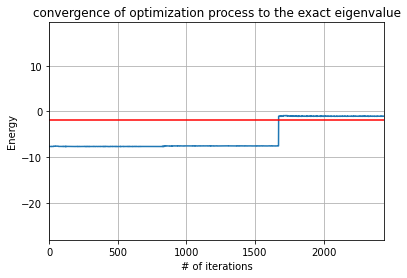

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01,  8.62it/s]
15it [00:01,  8.78it/s]
15it [00:01,  8.99it/s]
15it [00:01,  7.99it/s]
15it [00:01,  8.15it/s]
15it [00:01,  8.56it/s]
15it [00:01,  8.78it/s]
15it [00:01,  9.10it/s]
15it [00:01,  7.80it/s]
15it [00:01,  7.57it/s]
15it [00:01,  8.12it/s]
15it [00:01,  7.91it/s]
15it [00:01,  8.66it/s]
15it [00:01,  8.34it/s]
15it [00:01,  8.29it/s]
15it [00:01,  8.11it/s]
15it [00:01,  8.12it/s]
15it [00:01,  8.09it/s]
15it [00:01,  8.03it/s]
15it [00:01,  8.18it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.40it/s]
15it [00:01,  8.31it/s]
15it [00:01,  7.73it/s]
15it [00:01,  7.56it/s]
15it [00:01,  7.96it/s]
15it [00:01,  8.70it/s]
15it [00:01,  7.95it/s]
15it [00:01,  8.14it/s]
15it [00:01,  9.32it/s]
15it [00:01,  8.57it/s]
15it [00:01,  7.90it/s]
15it [00:01,  9.28it/s]
15it [00:01,  8.64it/s]
15it [00:01,  8.25it/s]
15it [00:01,  8.46it/s]
15it [00:01,  9.09it/s]
15it [00:01,  7.69it/s]
15it [00:01,  8.02it/s]
15it [00:01,  7.60it/s]
15it [00:01,  8.03it/s]
15it [00:01,  8.

15it [00:02,  7.29it/s]
15it [00:01,  8.41it/s]
15it [00:01,  7.83it/s]
15it [00:01,  8.52it/s]
15it [00:01,  8.20it/s]
15it [00:01,  7.87it/s]
15it [00:01,  8.33it/s]
15it [00:01,  8.93it/s]
15it [00:01,  9.58it/s]
15it [00:01,  8.26it/s]
15it [00:01,  8.02it/s]
15it [00:01,  8.93it/s]
15it [00:01,  9.17it/s]
15it [00:01,  9.01it/s]
15it [00:02,  7.35it/s]
15it [00:01,  8.54it/s]
15it [00:01,  9.06it/s]
15it [00:01,  9.08it/s]
15it [00:01,  9.51it/s]
15it [00:01,  9.48it/s]
15it [00:01,  8.91it/s]
15it [00:01,  8.10it/s]
15it [00:01,  9.30it/s]
15it [00:01,  7.79it/s]
15it [00:01,  8.30it/s]
15it [00:01,  8.98it/s]
15it [00:01,  9.17it/s]
15it [00:01,  9.23it/s]
15it [00:01,  8.53it/s]
15it [00:01,  8.74it/s]
15it [00:01,  7.95it/s]
15it [00:01,  8.34it/s]
15it [00:01,  8.00it/s]
15it [00:01,  8.13it/s]
15it [00:01,  8.60it/s]
15it [00:01,  9.98it/s]
15it [00:01,  9.25it/s]
15it [00:01,  8.58it/s]
15it [00:01,  8.31it/s]
15it [00:01,  8.90it/s]
15it [00:01,  8.79it/s]
15it [00:01,  8.

         Current function value: -0.922185
         Iterations: 1
         Function evaluations: 666
         Gradient evaluations: 20
[5.14061918 6.0272176  2.22828673 2.96351695 2.01870188 6.08193395
 3.59677807 1.59038537 2.37616712 5.14978832 2.73168134 4.20138191
 4.29811912 3.63633524 4.61348593 4.28591566 1.05187055 4.99882689
 0.17359177 3.15822039 4.46759897 2.48041229 1.63154711 4.56890013
 6.16551286 5.75632716 3.46807588 2.58760131 3.60160151 4.35261822
 4.84932634 5.46078751]


15it [00:01,  8.78it/s]

CPU times: total: 19min 14s
Wall time: 19min 40s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.9111741805791166

Approximation Error
0.5094026647847466


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


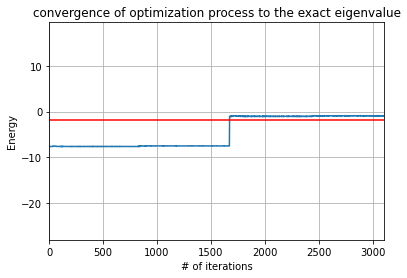

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  7.27it/s]
11it [00:01,  8.43it/s]
11it [00:01,  9.98it/s]
11it [1:24:03, 458.53s/it]
11it [00:00, 12.26it/s]
11it [00:01,  9.97it/s]
11it [00:00, 11.47it/s]
11it [00:00, 11.23it/s]
11it [00:00, 12.00it/s]
11it [00:00, 13.95it/s]
11it [00:00, 14.32it/s]
11it [00:00, 14.81it/s]
11it [00:00, 14.80it/s]
11it [00:00, 14.32it/s]
11it [00:00, 14.05it/s]
11it [00:00, 15.34it/s]
11it [00:00, 16.72it/s]
11it [00:00, 14.48it/s]
11it [00:00, 13.15it/s]
11it [00:00, 13.28it/s]
11it [00:00, 13.50it/s]
11it [00:00, 14.30it/s]
11it [00:00, 13.52it/s]
11it [00:00, 14.33it/s]
11it [00:00, 13.42it/s]
11it [00:00, 13.91it/s]
11it [00:00, 12.81it/s]
11it [00:00, 12.99it/s]
11it [00:01, 10.57it/s]
11it [00:00, 12.53it/s]
11it [00:00, 12.18it/s]
11it [00:00, 12.73it/s]
11it [00:01, 10.55it/s]
11it [00:01, 10.99it/s]
11it [00:01, 10.80it/s]
11it [00:00, 11.03it/s]
11it [00:01, 10.29it/s]
11it [00:01, 10.03it/s]
11it [00:01,  9.22it/s]
11it [00:01,  9.24it/s]
11it [00:01,  9.71it/s]
11it [00:01, 

11it [00:01,  7.73it/s]
11it [00:01,  7.97it/s]
11it [00:01,  7.79it/s]
11it [00:01,  7.36it/s]
11it [00:01,  7.99it/s]
11it [00:01,  8.32it/s]
11it [00:01,  8.52it/s]
11it [00:01,  8.06it/s]
11it [00:01,  7.98it/s]
11it [00:01,  8.26it/s]
11it [00:01,  7.24it/s]
11it [00:01,  8.23it/s]
11it [00:01,  7.84it/s]
11it [00:01,  7.85it/s]
11it [00:01,  7.73it/s]
11it [00:01,  8.83it/s]
11it [00:01,  8.30it/s]
11it [00:01,  8.27it/s]
11it [00:01,  8.20it/s]
11it [00:01,  7.73it/s]
11it [00:01,  8.37it/s]
11it [00:01,  8.27it/s]
11it [00:01,  8.16it/s]
11it [00:01,  8.12it/s]
11it [00:01,  7.96it/s]
11it [00:01,  8.54it/s]
11it [00:01,  7.39it/s]
11it [00:01,  6.77it/s]
11it [00:01,  7.42it/s]
11it [00:01,  8.30it/s]
11it [00:01,  8.08it/s]
11it [00:01,  7.97it/s]
11it [00:01,  9.11it/s]
11it [00:01,  7.81it/s]
11it [00:01,  8.28it/s]
11it [00:01,  7.55it/s]
11it [00:01,  7.42it/s]
11it [00:01,  8.12it/s]
11it [00:01,  8.50it/s]
11it [00:01,  8.10it/s]
11it [00:01,  8.29it/s]
11it [00:01,  8.

11it [00:01,  6.41it/s]
11it [00:01,  6.36it/s]
11it [00:01,  7.42it/s]
11it [00:01,  7.00it/s]
11it [00:01,  7.25it/s]
11it [00:01,  6.57it/s]
11it [00:01,  7.25it/s]
11it [00:01,  7.22it/s]
11it [00:01,  6.70it/s]
11it [00:01,  6.75it/s]
11it [00:01,  7.34it/s]
11it [00:01,  6.54it/s]
11it [00:01,  7.26it/s]
11it [00:01,  6.80it/s]
11it [00:01,  6.89it/s]
11it [00:01,  6.88it/s]
11it [00:01,  7.36it/s]
11it [00:01,  7.42it/s]
11it [00:01,  7.87it/s]
11it [00:01,  7.94it/s]
11it [00:01,  6.84it/s]
11it [00:01,  7.29it/s]
11it [00:01,  7.52it/s]
11it [00:01,  7.09it/s]
11it [00:01,  7.69it/s]
11it [00:01,  7.71it/s]
11it [00:01,  7.55it/s]
11it [00:01,  7.86it/s]
11it [00:01,  7.62it/s]
11it [00:01,  6.87it/s]
11it [00:01,  7.67it/s]
11it [00:01,  7.54it/s]
11it [00:01,  5.67it/s]
11it [00:01,  5.78it/s]
11it [00:02,  5.42it/s]
11it [00:01,  6.70it/s]
11it [00:01,  7.34it/s]
11it [00:01,  7.12it/s]
11it [00:01,  7.10it/s]
11it [00:02,  4.72it/s]
11it [00:01,  5.78it/s]
11it [00:01,  6.

         Current function value: -0.497254
         Iterations: 0
         Function evaluations: 804
         Gradient evaluations: 24
[3.6468435  2.60442014 1.42308667 0.43080058 2.56691988 4.84601781
 0.74741107 0.72295054 4.25408615 2.03740954 3.43164951 2.97801116
 2.50008002 3.56329781 4.25406603 6.1799383  1.03620427 2.84842121
 5.83690015 4.90023901 0.55999687 4.28401875 0.66217774 0.66529903
 5.87135871 1.94316516 4.29191973 1.67332076 5.76883972 2.29505247
 3.97992876 3.30832414]


11it [00:01,  9.80it/s]

CPU times: total: 16min 44s
Wall time: 1h 42min 8s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.4131961037378728

Approximation Error
0.7933487953781705


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


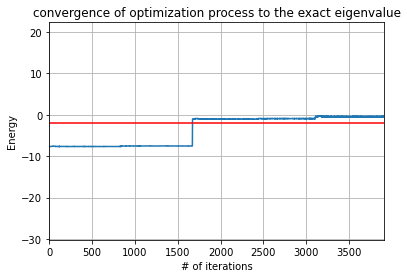

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  8.86it/s]
11it [00:01, 10.23it/s]
11it [00:01,  9.62it/s]
11it [00:01,  9.63it/s]
11it [00:01,  9.70it/s]
11it [00:01,  9.00it/s]
11it [00:01,  9.96it/s]
11it [00:01,  9.52it/s]
11it [00:01,  9.19it/s]
11it [00:00, 11.12it/s]
11it [00:01,  9.30it/s]
11it [00:01,  8.98it/s]
11it [00:01,  9.63it/s]
11it [00:01,  8.90it/s]
11it [00:01,  9.33it/s]
11it [00:01,  9.49it/s]
11it [00:01,  9.40it/s]
11it [00:01, 10.03it/s]
11it [00:01,  8.69it/s]
11it [00:01,  8.60it/s]
11it [00:01,  8.91it/s]
11it [00:01, 10.62it/s]
11it [00:01, 10.30it/s]
11it [00:01,  9.12it/s]
11it [00:01,  8.74it/s]
11it [00:01,  9.03it/s]
11it [00:01, 10.09it/s]
11it [00:01, 10.07it/s]
11it [00:01,  8.82it/s]
11it [00:01,  8.72it/s]
11it [00:01,  8.57it/s]
11it [00:01,  9.14it/s]
11it [00:01,  9.98it/s]
11it [00:01,  9.04it/s]
11it [00:01,  8.66it/s]
11it [00:01,  9.84it/s]
11it [00:01,  8.85it/s]
11it [00:01,  9.85it/s]
11it [00:01,  9.37it/s]
11it [00:01,  9.91it/s]
11it [00:01,  9.47it/s]
11it [00:01,  8.

11it [00:01,  5.60it/s]
11it [00:01,  6.27it/s]
11it [00:01,  6.02it/s]
11it [00:01,  5.66it/s]
11it [00:01,  6.17it/s]
11it [00:01,  6.10it/s]
11it [00:01,  6.63it/s]
11it [00:01,  6.22it/s]
11it [00:01,  6.75it/s]
11it [00:01,  6.42it/s]
11it [00:01,  6.25it/s]
11it [00:01,  5.89it/s]
11it [00:01,  6.17it/s]
11it [00:01,  7.16it/s]
11it [00:01,  6.76it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.63it/s]
11it [00:01,  7.23it/s]
11it [00:01,  6.90it/s]
11it [00:01,  6.61it/s]
11it [00:01,  5.73it/s]
11it [00:01,  6.38it/s]
11it [00:01,  6.97it/s]
11it [00:01,  7.43it/s]
11it [00:01,  7.40it/s]
11it [00:01,  7.77it/s]
11it [00:01,  5.96it/s]
11it [00:01,  5.77it/s]
11it [00:01,  7.03it/s]
11it [00:01,  6.29it/s]
11it [00:01,  5.77it/s]
11it [00:01,  6.66it/s]
11it [00:01,  6.15it/s]
11it [00:01,  5.99it/s]
11it [00:01,  5.56it/s]
11it [00:01,  6.93it/s]
11it [00:01,  6.99it/s]
11it [00:01,  7.39it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.81it/s]
11it [00:01,  6.

11it [00:01,  6.37it/s]
11it [00:01,  6.31it/s]
11it [00:01,  6.12it/s]
11it [00:01,  6.53it/s]
11it [00:01,  6.54it/s]
11it [00:01,  6.34it/s]
11it [00:01,  6.95it/s]
11it [00:01,  7.43it/s]
11it [00:01,  5.96it/s]
11it [00:01,  6.66it/s]
11it [00:01,  6.93it/s]
11it [00:01,  7.33it/s]
11it [00:01,  7.11it/s]
11it [00:01,  6.67it/s]
11it [00:01,  6.51it/s]
11it [00:01,  7.00it/s]
11it [00:01,  6.93it/s]
11it [00:01,  6.23it/s]
11it [00:01,  6.41it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.76it/s]
11it [00:01,  6.51it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.43it/s]
11it [00:01,  7.10it/s]
11it [00:01,  6.19it/s]
11it [00:01,  7.05it/s]
11it [00:01,  7.16it/s]
11it [00:01,  7.50it/s]
11it [00:01,  9.73it/s]
11it [00:01,  7.53it/s]
11it [00:01,  8.55it/s]
11it [00:01,  8.93it/s]
11it [00:01,  7.76it/s]
11it [00:01,  8.23it/s]
11it [00:01,  8.05it/s]
11it [00:01,  5.56it/s]
11it [00:01,  5.87it/s]
11it [00:01,  5.97it/s]
11it [00:01,  6.51it/s]
11it [00:01,  6.24it/s]
11it [00:01,  6.

         Current function value: 0.536941
         Iterations: 3
         Function evaluations: 802
         Gradient evaluations: 24
[4.39473931 3.08507015 0.38152102 1.85031044 4.20222701 5.73718565
 2.64206599 4.99284363 1.48383352 2.29833002 5.89989475 0.12435925
 3.3784272  1.90782092 1.54479534 0.21188324 4.83334689 5.31314768
 2.20032757 2.23918584 3.62967735 2.02513421 4.42489068 3.68258464
 3.81659446 5.25719715 2.1467906  4.37885436 4.09194393 5.1657276
 4.65531955 5.16919413]


11it [00:01,  6.32it/s]

CPU times: total: 19min 33s
Wall time: 21min 33s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.5897739576542677

Approximation Error
0.7050371537841121


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


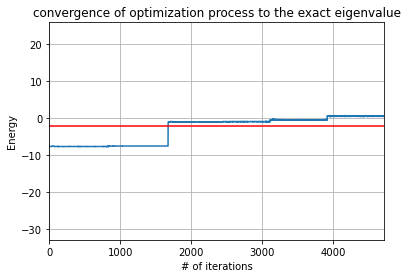

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  7.16it/s]
7it [00:00,  8.41it/s]
7it [00:00,  7.91it/s]
7it [00:00,  8.17it/s]
7it [00:00,  8.93it/s]
7it [00:00,  8.14it/s]
7it [00:00,  8.95it/s]
7it [00:00,  8.46it/s]
7it [00:00,  8.51it/s]
7it [00:00,  9.73it/s]
7it [00:00,  8.70it/s]
7it [00:00,  8.55it/s]
7it [00:00,  7.19it/s]
7it [00:00,  8.43it/s]
7it [00:00,  8.04it/s]
7it [00:00,  8.48it/s]
7it [00:00,  7.31it/s]
7it [00:00,  9.39it/s]
7it [00:00,  8.13it/s]
7it [00:00,  8.17it/s]
7it [00:00,  9.93it/s]
7it [00:00,  9.64it/s]
7it [00:00,  8.94it/s]
7it [00:00,  8.84it/s]
7it [00:00,  9.34it/s]
7it [00:00,  7.88it/s]
7it [00:00,  9.92it/s]
7it [00:00,  8.58it/s]
7it [00:00,  8.85it/s]
7it [00:00,  8.73it/s]
7it [00:00,  8.57it/s]
7it [00:00,  8.62it/s]
7it [00:00,  8.91it/s]
7it [00:00,  9.70it/s]
7it [00:00,  8.45it/s]
7it [00:00,  9.57it/s]
7it [00:00,  8.82it/s]
7it [00:00,  8.21it/s]
7it [00:00,  9.17it/s]
7it [00:00,  9.43it/s]
7it [00:00,  8.26it/s]
7it [00:00,  9.02it/s]
7it [00:00,  9.13it/s]
7it [00:00,

7it [00:00, 12.47it/s]
7it [00:00, 12.51it/s]
7it [00:00, 11.08it/s]
7it [00:00,  9.96it/s]
7it [00:00, 10.24it/s]
7it [00:00, 12.29it/s]
7it [00:00, 12.35it/s]
7it [00:00, 11.07it/s]
7it [00:00, 10.96it/s]
7it [00:00, 11.58it/s]
7it [00:00, 12.18it/s]
7it [00:00, 12.28it/s]
7it [00:00, 11.51it/s]
7it [00:00, 10.98it/s]
7it [00:00,  9.52it/s]
7it [00:00,  9.41it/s]
7it [00:00, 11.48it/s]
7it [00:00, 11.43it/s]
7it [00:00, 12.62it/s]
7it [00:00, 15.94it/s]
7it [00:00, 12.55it/s]
7it [00:00, 12.83it/s]
7it [00:00, 12.41it/s]
7it [00:00, 13.51it/s]
7it [00:00, 12.28it/s]
7it [00:00, 10.40it/s]
7it [00:00, 10.86it/s]
7it [00:00, 11.76it/s]
7it [00:00, 13.29it/s]
7it [00:00, 15.04it/s]
7it [00:00, 12.50it/s]
7it [00:00, 11.17it/s]
7it [00:00, 11.86it/s]
7it [00:00, 12.20it/s]
7it [00:00, 13.21it/s]
7it [00:00, 12.50it/s]
7it [00:00, 10.03it/s]
7it [00:00, 11.04it/s]
7it [00:00, 11.08it/s]
7it [00:00, 14.81it/s]
7it [00:00, 10.93it/s]
7it [00:00, 12.21it/s]
7it [00:00, 12.21it/s]
7it [00:00,

         Current function value: -0.343074
         Iterations: 0
         Function evaluations: 612
         Gradient evaluations: 24
[2.85500802 0.02623462 2.38977683 4.47533242 5.97899386 5.13292519
 4.74563137 1.0369105  4.98485845 3.95309025 0.79034252 5.63093186
 4.72956537 5.65565078 5.41414785 1.07477604 5.32560533 6.22231511
 3.57929482 0.32578006 1.48228822 1.67836952 2.51910862 4.36203154]


7it [00:00, 10.86it/s]

CPU times: total: 6min 17s
Wall time: 6min 39s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.31692390167634304

Approximation Error
0.7202074283497167


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


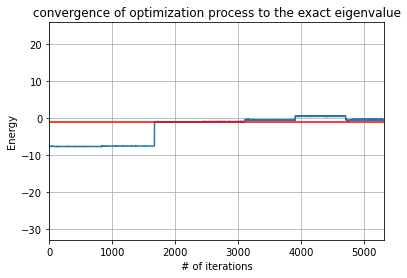

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 12.98it/s]
7it [00:00, 12.44it/s]
7it [00:00, 12.49it/s]
7it [00:00, 12.70it/s]
7it [00:00, 15.48it/s]
7it [00:00, 11.55it/s]
7it [00:00, 11.68it/s]
7it [00:00, 12.23it/s]
7it [00:00, 13.30it/s]
7it [00:00, 12.35it/s]
7it [00:00, 14.01it/s]
7it [00:00, 11.75it/s]
7it [00:00, 11.76it/s]
7it [00:00, 12.95it/s]
7it [00:00, 12.91it/s]
7it [00:00, 12.72it/s]
7it [00:00, 10.77it/s]
7it [00:00, 12.63it/s]
7it [00:00, 13.16it/s]
7it [00:00, 14.36it/s]
7it [00:00, 11.46it/s]
7it [00:00, 12.21it/s]
7it [00:00, 10.87it/s]
7it [00:00, 14.95it/s]
7it [00:00, 12.61it/s]
7it [00:00, 11.76it/s]
7it [00:00, 12.86it/s]
7it [00:00, 12.08it/s]
7it [00:00, 11.33it/s]
7it [00:00, 11.09it/s]
7it [00:00,  9.99it/s]
7it [00:00,  8.85it/s]
7it [00:00,  8.34it/s]
7it [00:00, 10.73it/s]
7it [00:00,  8.36it/s]
7it [00:00,  9.95it/s]
7it [00:00, 10.04it/s]
7it [00:00, 10.12it/s]
7it [00:00, 13.86it/s]
7it [00:00, 10.44it/s]
7it [00:00,  8.44it/s]
7it [00:00, 10.40it/s]
7it [00:00, 10.24it/s]
7it [00:00,

7it [00:00,  7.99it/s]
7it [00:00,  8.36it/s]
7it [00:00,  8.85it/s]
7it [00:00,  7.34it/s]
7it [00:00,  9.18it/s]
7it [00:00,  8.24it/s]
7it [00:00,  7.79it/s]
7it [00:00,  7.92it/s]
7it [00:00,  8.64it/s]
7it [00:00,  8.06it/s]
7it [00:00,  9.50it/s]
7it [00:00,  9.49it/s]
7it [00:00,  9.26it/s]
7it [00:00,  8.87it/s]
7it [00:00,  9.51it/s]
7it [00:00, 10.40it/s]
7it [00:00,  9.57it/s]
7it [00:00,  8.71it/s]
7it [00:00,  9.89it/s]
7it [00:00,  8.47it/s]
7it [00:00,  8.96it/s]
7it [00:00,  8.32it/s]
7it [00:00,  8.61it/s]
7it [00:00,  9.28it/s]
7it [00:00,  8.53it/s]
7it [00:00,  8.18it/s]
7it [00:00,  9.29it/s]
7it [00:00, 10.64it/s]
7it [00:00,  7.66it/s]
7it [00:00,  9.46it/s]
7it [00:00,  9.97it/s]
7it [00:00,  8.73it/s]
7it [00:00,  9.11it/s]
7it [00:00,  8.87it/s]
7it [00:00, 10.21it/s]
7it [00:00,  8.69it/s]
7it [00:00,  8.31it/s]
7it [00:00,  8.88it/s]
7it [00:00,  9.66it/s]
7it [00:00,  9.81it/s]
7it [00:00, 10.51it/s]
7it [00:00,  9.96it/s]
7it [00:00,  9.49it/s]
7it [00:00,

         Current function value: -0.018403
         Iterations: 2
         Function evaluations: 617
         Gradient evaluations: 24
[0.16905066 4.70896999 1.17103523 4.22940324 0.5242834  0.49720878
 6.05368062 3.2890047  2.09327218 5.3395971  2.13530411 1.83795472
 2.71489997 0.30078391 4.81191179 0.91950734 1.29811752 5.04055557
 3.02360315 2.29848718 3.1894232  2.51108944 0.50399481 0.85039822]


7it [00:00,  9.34it/s]


CPU times: total: 7min 24s
Wall time: 8min 13s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.004066137107481091

Approximation Error
0.9964102582608407


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


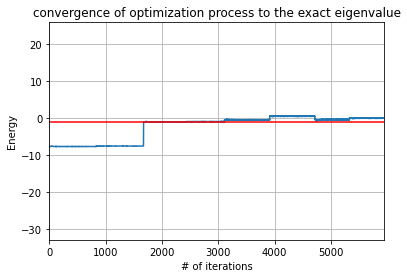

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 12.78it/s]
3it [00:00, 12.56it/s]
3it [00:00, 11.13it/s]
3it [00:00, 10.40it/s]
3it [00:00, 10.42it/s]
3it [00:00, 11.53it/s]
3it [00:00, 11.77it/s]
3it [00:00,  9.16it/s]
3it [00:00, 11.30it/s]
3it [00:00, 11.00it/s]
3it [00:00, 10.62it/s]
3it [00:00, 18.13it/s]
3it [00:00, 12.11it/s]
3it [00:00, 14.09it/s]
3it [00:00, 19.15it/s]
3it [00:00, 11.02it/s]
3it [00:00, 13.28it/s]
3it [00:00, 13.88it/s]
3it [00:00,  8.13it/s]
3it [00:00, 11.43it/s]
3it [00:00,  9.53it/s]
3it [00:00, 12.27it/s]
3it [00:00, 14.77it/s]
3it [00:00, 12.42it/s]
3it [00:00, 13.74it/s]
3it [00:00, 12.34it/s]
3it [00:00, 11.14it/s]
3it [00:00, 12.97it/s]
3it [00:00, 11.27it/s]
3it [00:00, 10.50it/s]
3it [00:00, 15.49it/s]
3it [00:00, 11.93it/s]
3it [00:00, 12.65it/s]
3it [00:00, 12.76it/s]
3it [00:00, 12.24it/s]
3it [00:00, 12.20it/s]
3it [00:00, 12.48it/s]
3it [00:00, 11.25it/s]
3it [00:00, 10.96it/s]
3it [00:00, 13.05it/s]
3it [00:00, 10.75it/s]
3it [00:00, 14.94it/s]
3it [00:00, 14.58it/s]
3it [00:00,

3it [00:00, 12.14it/s]
3it [00:00, 12.33it/s]
3it [00:00, 11.82it/s]
3it [00:00, 12.17it/s]
3it [00:00, 11.86it/s]
3it [00:00, 10.78it/s]
3it [00:00,  8.36it/s]
3it [00:00, 10.88it/s]
3it [00:00, 12.81it/s]
3it [00:00, 11.13it/s]
3it [00:00, 13.17it/s]
3it [00:00, 11.26it/s]
3it [00:00, 13.99it/s]
3it [00:00, 17.20it/s]
3it [00:00, 11.23it/s]
3it [00:00, 12.45it/s]
3it [00:00, 11.96it/s]
3it [00:00,  9.60it/s]
3it [00:00, 12.13it/s]
3it [00:00, 16.00it/s]
3it [00:00, 11.65it/s]
3it [00:00, 13.30it/s]
3it [00:00, 11.51it/s]
3it [00:00,  9.76it/s]
3it [00:00, 12.47it/s]
3it [00:00,  9.50it/s]
3it [00:00, 14.96it/s]
3it [00:00, 10.99it/s]
3it [00:00, 13.12it/s]
3it [00:00, 17.17it/s]
3it [00:00, 16.21it/s]
3it [00:00, 10.16it/s]
3it [00:00, 20.25it/s]
3it [00:00, 15.03it/s]
3it [00:00, 10.34it/s]
3it [00:00, 10.77it/s]
3it [00:00, 12.83it/s]
3it [00:00, 12.83it/s]
3it [00:00, 14.54it/s]
3it [00:00, 12.76it/s]
3it [00:00, 10.64it/s]
3it [00:00, 12.83it/s]
3it [00:00, 13.81it/s]
3it [00:00,

         Current function value: -0.148900
         Iterations: 3
         Function evaluations: 574
         Gradient evaluations: 33
[1.0010206  0.9163896  1.32602791 4.90310014 0.92858505 4.30066267
 4.42490211 2.13787754 5.49200428 5.15301213 3.71795741 1.20315031
 2.48956167 3.49572367 3.42288763 1.16326901]


3it [00:00, 11.32it/s]

CPU times: total: 2min 12s
Wall time: 2min 26s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.15659200618011315

Approximation Error
0.8475210389045745


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


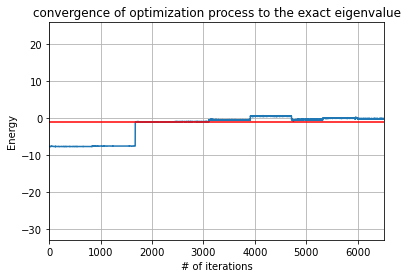

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 12.41it/s]
3it [00:00, 12.21it/s]
3it [00:00, 13.59it/s]
3it [00:00, 11.38it/s]
3it [00:00, 13.41it/s]
3it [00:00, 10.03it/s]
3it [00:00, 11.01it/s]
3it [00:00, 10.74it/s]
3it [00:00, 14.81it/s]
3it [00:00, 16.30it/s]
3it [00:00, 13.61it/s]
3it [00:00, 11.01it/s]
3it [00:00, 12.66it/s]
3it [00:00, 12.38it/s]
3it [00:00, 12.48it/s]
3it [00:00, 12.39it/s]
3it [00:00, 11.09it/s]
3it [00:00, 14.43it/s]
3it [00:00,  9.96it/s]
3it [00:00, 11.77it/s]
3it [00:00, 15.16it/s]
3it [00:00, 14.20it/s]
3it [00:00, 10.74it/s]
3it [00:00, 13.25it/s]
3it [00:00, 12.29it/s]
3it [00:00, 11.41it/s]
3it [00:00, 12.48it/s]
3it [00:00, 14.95it/s]
3it [00:00, 11.30it/s]
3it [00:00, 14.01it/s]
3it [00:00, 11.80it/s]
3it [00:00, 11.87it/s]
3it [00:00, 13.23it/s]
3it [00:00, 11.91it/s]
3it [00:00, 12.15it/s]
3it [00:00, 13.89it/s]
3it [00:00, 11.69it/s]
3it [00:00, 10.98it/s]
3it [00:00, 12.52it/s]
3it [00:00,  9.72it/s]
3it [00:00, 11.48it/s]
3it [00:00, 15.28it/s]
3it [00:00,  9.91it/s]
3it [00:00,

         Current function value: 0.242111
         Iterations: 1
         Function evaluations: 351
         Gradient evaluations: 20
[0.97534785 3.82612516 5.29080881 5.42319777 2.79180494 5.54406509
 3.93383063 2.57733299 4.83174706 4.718041   3.82461118 4.25588564
 3.38717103 1.76949513 5.15814628 3.78894256]


3it [00:00, 12.14it/s]

CPU times: total: 1min 18s
Wall time: 1min 28s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.2506377973304442

Approximation Error
0.7559454541744967


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


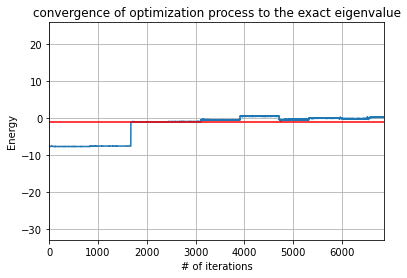

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00,  9.15it/s]
4it [00:00, 13.20it/s]
4it [00:00, 11.00it/s]
4it [00:00, 14.00it/s]
4it [00:00, 11.94it/s]
4it [00:00, 14.41it/s]
4it [00:00, 11.40it/s]
4it [00:00, 13.05it/s]
4it [00:00, 11.44it/s]
4it [00:00, 13.29it/s]
4it [00:00, 10.17it/s]
4it [00:00, 12.76it/s]
4it [00:00, 12.98it/s]
4it [00:00, 14.03it/s]
4it [00:00, 11.50it/s]
4it [00:00, 13.54it/s]
4it [00:00,  9.91it/s]
4it [00:00, 11.54it/s]
4it [00:00, 12.90it/s]
4it [00:00, 13.32it/s]
4it [00:00, 12.08it/s]
4it [00:00, 13.22it/s]
4it [00:00, 13.02it/s]
4it [00:00, 12.64it/s]
4it [00:00, 11.92it/s]
4it [00:00, 13.18it/s]
4it [00:00, 12.33it/s]
4it [00:00, 10.86it/s]
4it [00:00, 12.77it/s]
4it [00:00, 11.81it/s]
4it [00:00, 13.68it/s]
4it [00:00, 12.69it/s]
4it [00:00, 12.36it/s]
4it [00:00, 13.49it/s]
4it [00:00, 11.86it/s]
4it [00:00, 13.40it/s]
4it [00:00, 11.42it/s]
4it [00:00, 10.56it/s]
4it [00:00, 12.33it/s]
4it [00:00, 12.93it/s]
4it [00:00, 12.04it/s]
4it [00:00, 12.52it/s]
4it [00:00, 11.32it/s]
4it [00:00,

4it [00:00, 10.97it/s]
4it [00:00, 11.02it/s]
4it [00:00, 10.56it/s]
4it [00:00, 11.79it/s]
4it [00:00, 12.94it/s]
4it [00:00, 13.26it/s]
4it [00:00, 11.53it/s]
4it [00:00,  9.84it/s]
4it [00:00, 14.68it/s]
4it [00:00, 12.15it/s]
4it [00:00,  9.55it/s]
4it [00:00,  9.04it/s]
4it [00:00, 10.09it/s]
4it [00:00, 11.69it/s]
4it [00:00, 12.76it/s]
4it [00:00, 12.34it/s]
4it [00:00, 12.00it/s]
4it [00:00,  9.95it/s]
4it [00:00, 12.25it/s]
4it [00:00, 10.60it/s]
4it [00:00, 12.45it/s]
4it [00:00,  9.75it/s]
4it [00:00, 10.73it/s]
4it [00:00, 11.64it/s]
4it [00:00, 11.91it/s]
4it [00:00, 11.47it/s]
4it [00:00, 14.01it/s]
4it [00:00, 12.66it/s]
4it [00:00, 13.17it/s]
4it [00:00, 12.25it/s]
4it [00:00, 12.12it/s]
4it [00:00, 15.25it/s]
4it [00:00, 11.49it/s]
4it [00:00, 13.99it/s]
4it [00:00, 13.32it/s]
4it [00:00, 15.12it/s]
4it [00:00, 11.38it/s]
4it [00:00, 14.29it/s]
4it [00:00, 10.93it/s]
4it [00:00, 12.79it/s]
4it [00:00, 11.33it/s]
4it [00:00, 13.10it/s]
4it [00:00, 12.32it/s]
4it [00:00,

         Current function value: -0.588489
         Iterations: 3
         Function evaluations: 488
         Gradient evaluations: 28
[4.58730253 1.93745517 4.25020049 0.83048945 2.0565405  1.0633158
 6.12062989 2.3367563  0.28646779 1.73089541 0.9102614  1.21532301
 4.30795761 0.25494808 1.19632957 5.68387878]


4it [00:00,  8.50it/s]

CPU times: total: 2min 31s
Wall time: 2min 49s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.5512020425676079

Approximation Error
0.4515984821416123


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


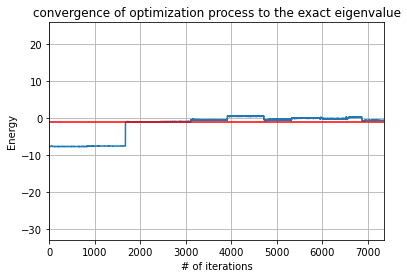

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 12.09it/s]
4it [00:00,  9.64it/s]
4it [00:00, 12.20it/s]
4it [00:00,  8.95it/s]
4it [00:00, 12.38it/s]
4it [00:00,  8.75it/s]
4it [00:00, 11.06it/s]
4it [00:00,  8.26it/s]
4it [00:00,  8.07it/s]
4it [00:00, 10.99it/s]
4it [00:00,  8.87it/s]
4it [00:00, 13.84it/s]
4it [00:00, 10.78it/s]
4it [00:00, 10.63it/s]
4it [00:00,  8.71it/s]
4it [00:00,  9.55it/s]
4it [00:00, 11.19it/s]
4it [00:00,  9.27it/s]
4it [00:00, 11.94it/s]
4it [00:00,  8.56it/s]
4it [00:00, 11.39it/s]
4it [00:00,  9.36it/s]
4it [00:00, 11.11it/s]
4it [00:00,  8.21it/s]
4it [00:00, 10.63it/s]
4it [00:00, 10.05it/s]
4it [00:00,  9.57it/s]
4it [00:00,  8.94it/s]
4it [00:00,  8.43it/s]
4it [00:00,  8.94it/s]
4it [00:00,  9.78it/s]
4it [00:00,  8.82it/s]
4it [00:00,  9.12it/s]
4it [00:00,  9.42it/s]
4it [00:00, 12.06it/s]
4it [00:00, 13.70it/s]
4it [00:00,  9.56it/s]
4it [00:00, 10.86it/s]
4it [00:00,  7.90it/s]
4it [00:00, 10.66it/s]
4it [00:00, 15.03it/s]
4it [00:00,  9.03it/s]
4it [00:00, 11.48it/s]
4it [00:00,

4it [00:00, 12.23it/s]
4it [00:00, 17.71it/s]
4it [00:00, 12.84it/s]
4it [00:00, 14.67it/s]
4it [00:00, 17.07it/s]
4it [00:00, 21.07it/s]
4it [00:00, 12.79it/s]
4it [00:00, 20.14it/s]
4it [00:00, 18.91it/s]
4it [00:00, 13.76it/s]
4it [00:00, 15.23it/s]


         Current function value: -0.750036
         Iterations: 2
         Function evaluations: 367
         Gradient evaluations: 21
[2.91252171 1.58424401 4.30844838 2.5057004  5.98645909 6.14718001
 6.26656269 0.13643289 2.24061422 1.53284254 1.70634499 6.11964842
 0.18000587 4.0991487  5.50500815 0.56145737]


4it [00:00, 11.66it/s]

CPU times: total: 1min 51s
Wall time: 2min 4s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.7428829291892614

Approximation Error
0.26089147989957506


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


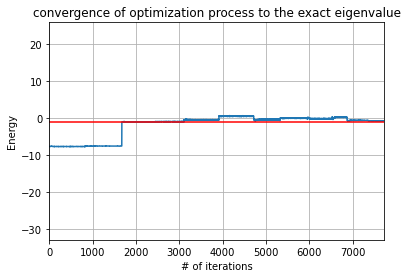

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)